Modele final: prediction utilisant Designation et Descriptions Camemeber + VIT

In [1]:
import os

import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adagrad
import numpy as np
import ast

2023-09-16 21:52:12.947380: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-16 21:52:12.973126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-16 21:52:12.973153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-16 21:52:12.973181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-16 21:52:12.978529: I tensorflow/core/platform/cpu_feature_guar

In [9]:

# PARAMS  de base
PATH = "images/crop224/"
img_size = 224
depth = 3

from RktnChallenge.RktnModel import ModelTrainer

trainer = ModelTrainer("embeddings_final.csv",PATH)

list_tags = trainer.data.prdtypecode.unique().tolist()
num_categories = len(list_tags)





X_data = trainer.data[["embeddings_desi","embeddings_desc","embedding_vit","designation_length_normalized","description_length_normalized"]]

def convert_string_to_nparray(s):    
    # Supprime les caractères non désirés et divise la chaîne en une liste de nombres
    numbers = [float(x) for x in s.replace("[", "").replace("]", "").split()]
    return np.array(numbers)
def translate_string_to_array(s):
    liste_python = ast.literal_eval(s)
    return np.array(liste_python)

X_data.loc[:, 'embeddings_desc'] = X_data['embeddings_desc'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi'] = X_data['embeddings_desi'].apply(convert_string_to_nparray)
X_data.loc[:, 'embedding_vit'] = X_data['embedding_vit'].apply(translate_string_to_array)

y = trainer.encodeLabel("prdtypecode")
label_size = trainer.getLabelSize()


In [10]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
X1_train = X_train["embeddings_desi"].values
X1_train = np.stack(X1_train).astype(np.float32)
X2_train = X_train["embeddings_desc"].values
X2_train = np.stack(X2_train).astype(np.float32)
X3_train = X_train["embedding_vit"].values
X3_train = np.stack(X3_train).astype(np.float32)
X4_train = X_train["designation_length_normalized"].values
X5_train = X_train["description_length_normalized"].values


X1_val = X_val["embeddings_desi"].values
X1_val = np.stack(X1_val).astype(np.float32)
X2_val = X_val["embeddings_desc"].values
X2_val = np.stack(X2_val).astype(np.float32)
X3_val = X_val["embedding_vit"].values
X3_val = np.stack(X3_val).astype(np.float32)
X4_val = X_val["designation_length_normalized"].values
X5_val = X_val["description_length_normalized"].values


X1_test = X_test["embeddings_desi"].values
X1_test = np.stack(X1_test).astype(np.float32)
X2_test = X_test["embeddings_desc"].values
X2_test = np.stack(X2_test).astype(np.float32)
X3_test = X_test["embedding_vit"].values
X3_test = np.stack(X3_test).astype(np.float32)
X4_test = X_test["designation_length_normalized"].values
X5_test = X_test["description_length_normalized"].values

#del X_data
del X_test
del X_train

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")
input_4 = Input(shape=(1,), name="input_4")
input_5 = Input(shape=(1,), name="input_5")

# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2,input_3, input_4,input_5])

x = Dense(512, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
model = Model(inputs=[input_1, input_2,input_3,input_4,input_5], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                            

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda,Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")
input_3 = Input(shape=(768,), name="input_3")

# Le merge des  towers
# Poids pour la moyenne pondérée
w_i1 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable
w_i2 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i3 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i4 = tf.Variable(initial_value=tf.zeros([768]), trainable=True, dtype=tf.float32)
#produit = Multiply()([input_1, input_2])
#difference = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([input_1, input_2])

# Fusion moyenne pondérée
moyenne = Lambda(lambda features: w_i1 * features[0] + w_i2 * features[1] + w_i3*features[2]+w_i4)([input_1, input_2, input_3])

#merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(moyenne)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
  <tf.Variable 'Variable:0' shape=(768,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  


 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 512)                  393728    ['lambda_1[0][0]']            
                                                                                                  
 dropout_6

In [69]:

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train, X4_train, X5_train], y_train, epochs=20, batch_size=32, validation_data=([X1_val, X2_val,X3_val,X4_val,X5_val], y_val),callbacks=[early_stopper])

Epoch 1/20
  25/1699 [..............................] - ETA: 10s - loss: 0.0776 - accuracy: 0.9825

2023-09-16 23:18:11.302982: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



1692/1699 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9761

2023-09-16 23:18:20.162742: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1699/1699 [==============================] - 10s 6ms/step - loss: 0.0819 - accuracy: 0.9761 - val_loss: 0.1118 - val_accuracy: 0.9682
Epoch 2/20
1699/1699 [==============================] - 10s 6ms/step - loss: 0.0797 - accuracy: 0.9768 - val_loss: 0.1106 - val_accuracy: 0.9686
Epoch 3/20
1699/1699 [==============================] - 9s 6ms/step - loss: 0.0766 - accuracy: 0.9781 - val_loss: 0.1099 - val_accuracy: 0.9681
Epoch 4/20
1699/1699 [==============================] - 10s 6ms/step - loss: 0.0738 - accuracy: 0.9784 - val_loss: 0.1106 - val_accuracy: 0.9681
Epoch 4: early stopping


In [68]:
early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 

model.fit([X1_train, X2_train, X3_train], y_train, epochs=1, batch_size=10, validation_data=([X1_val, X2_val,X3_val], y_val),callbacks=[early_stopper])

2023-09-16 23:17:30.772093: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



ValueError: in user code:

    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 5 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 768) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 768) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 768) dtype=float32>]


In [66]:
y_pred = model.predict([X1_test, X2_test,X3_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

2023-09-16 23:17:05.887149: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



ValueError: in user code:

    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 5 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 768) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 768) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 768) dtype=float32>]


 65/531 [==>...........................] - ETA: 1s

2023-09-16 23:19:00.855791: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.8870336431832727


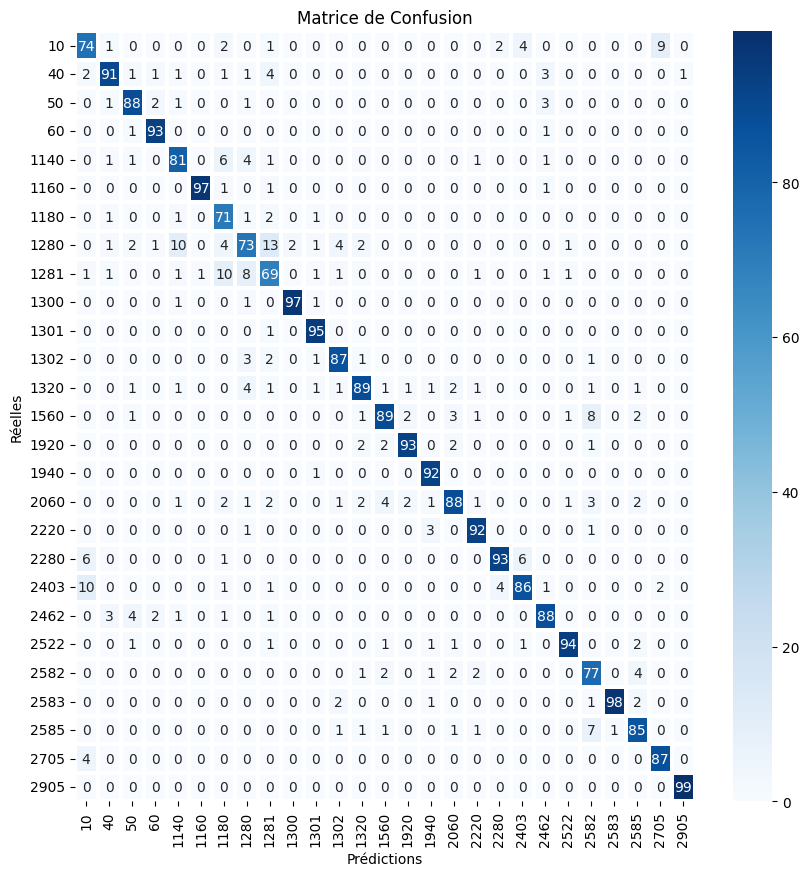

In [70]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 34/531 [>.............................] - ETA: 1s

2023-09-14 13:59:23.367817: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 2s 3ms/step
weighted F1 score: 0.8878551331939717


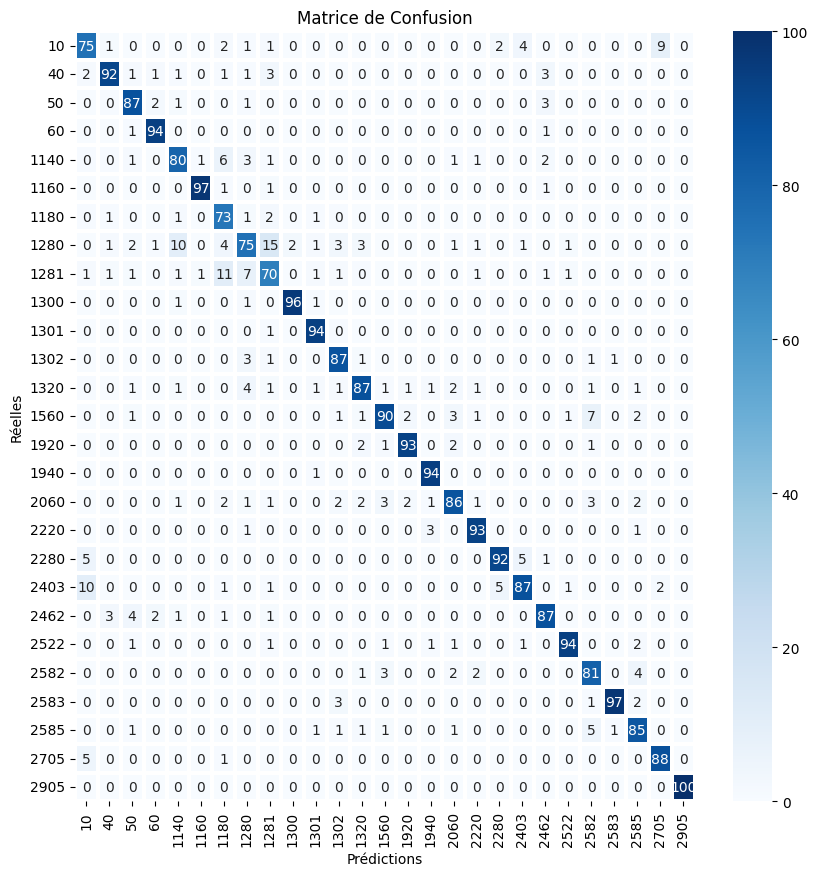

In [6]:
y_pred = model.predict([X1_test, X2_test,X3_test,X4_test,X5_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)

 49/531 [=>............................] - ETA: 1s

2023-09-14 00:00:42.151188: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.884816790453571


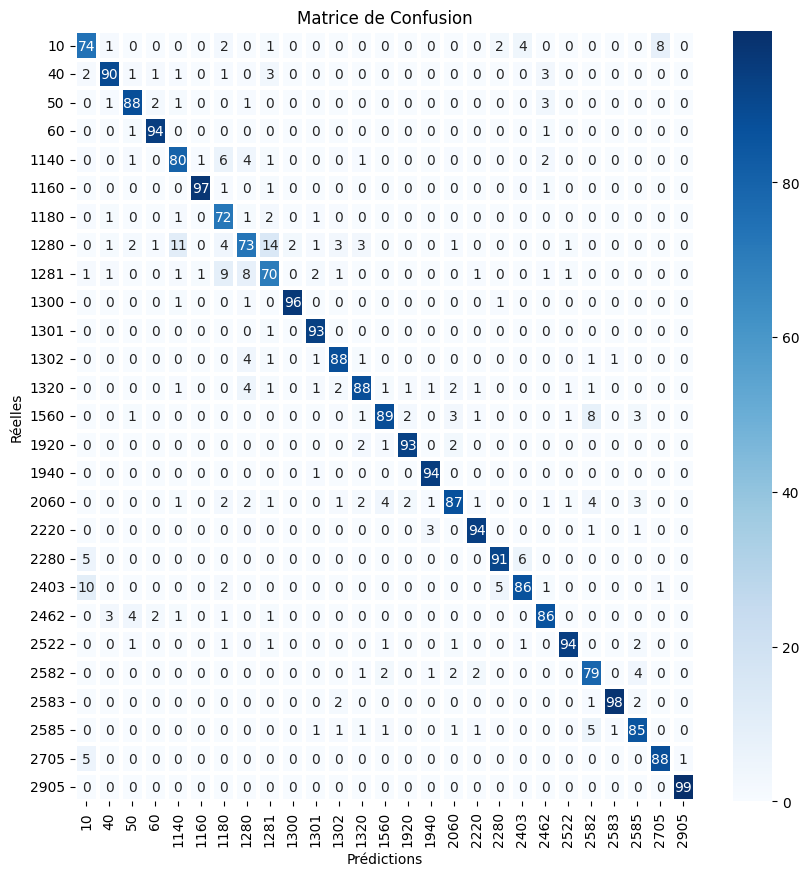

In [47]:
y_pred = model.predict([X1_test, X2_test,X3_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)